In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
from torch import nn

torch.__version__

'1.13.1'

## Multi-Class Classification

### Creating toy dataset

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [3]:
# Hyperparameter
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [4]:
X_blobs, y_blobs = make_blobs(n_samples=1000, 
n_features=NUM_FEATURES, 
centers=NUM_CLASSES,
cluster_std = 1.5, # noise,
random_state=RANDOM_SEED
)

In [5]:
# Splitting
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blobs,
                                                                        y_blobs,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

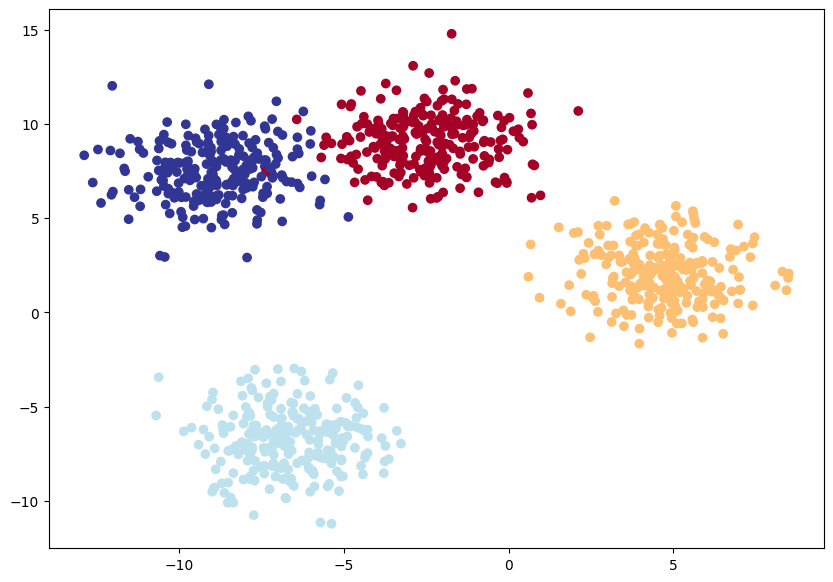

In [6]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap=plt.cm.RdYlBu)

In [7]:
#Turning data into tensors
X_blob_train = torch.from_numpy(X_blob_train).type(torch.float32)
y_blob_train = torch.from_numpy(y_blob_train).type(torch.float32)

X_blob_test = torch.from_numpy(X_blob_test).type(torch.float32)
y_blob_test = torch.from_numpy(y_blob_test).type(torch.float32)

### Building a multi-class classification model

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
X_blob_train.shape

torch.Size([800, 2])

In [10]:
torch.unique(y_blob_train)

tensor([0., 1., 2., 3.])

In [11]:
class BlobModel(nn.Module):

    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    

model_0 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Loss function and Optimizer

In [12]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### Getting Predictions probabilities for a multi-class PyTorch model

In [13]:
with torch.inference_mode():
    y_logits = model_0(X_blob_test.to(device))
    y_probs = nn.functional.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_probs, dim=1)
y_preds[:10]

tensor([2, 2, 2, 3, 2, 2, 2, 3, 2, 2], device='cuda:0')

In [14]:
y_blob_test[:10]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])

### Training and Testing loops

In [15]:
# Accuracy metrics
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = ( correct / len(y_pred) ) * 100
    return acc

In [16]:
y_blob_train.dtype

torch.float32

In [17]:
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.type(torch.LongTensor).to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.type(torch.LongTensor).to(device)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

for epoch in range(epochs):
    
    model_0.train()

    y_logits = model_0(X_blob_train)
    y_preds = torch.argmax( nn.functional.softmax(y_logits, dim=1), dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_pred=y_preds, y_true=y_blob_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_blob_test)
        test_preds = nn.functional.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_pred=test_preds, y_true=y_blob_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | test Loss: {test_loss:.4f} | acc: {acc} % | test_acc: {test_acc} %")

Epoch: 0 | Loss: 1.3617 | test Loss: 1.2622 | acc: 31.25 % | test_acc: 32.5 %
Epoch: 10 | Loss: 0.9626 | test Loss: 0.8943 | acc: 61.75000000000001 % | test_acc: 65.5 %
Epoch: 20 | Loss: 0.4112 | test Loss: 0.3444 | acc: 97.5 % | test_acc: 99.5 %
Epoch: 30 | Loss: 0.1324 | test Loss: 0.1171 | acc: 98.5 % | test_acc: 99.0 %
Epoch: 40 | Loss: 0.0780 | test Loss: 0.0698 | acc: 98.75 % | test_acc: 99.0 %
Epoch: 50 | Loss: 0.0583 | test Loss: 0.0516 | acc: 99.0 % | test_acc: 99.0 %
Epoch: 60 | Loss: 0.0484 | test Loss: 0.0421 | acc: 99.0 % | test_acc: 99.0 %
Epoch: 70 | Loss: 0.0427 | test Loss: 0.0364 | acc: 99.0 % | test_acc: 99.0 %
Epoch: 80 | Loss: 0.0390 | test Loss: 0.0324 | acc: 99.0 % | test_acc: 99.0 %
Epoch: 90 | Loss: 0.0364 | test Loss: 0.0296 | acc: 99.0 % | test_acc: 99.0 %


### Evaluation of model

In [23]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [18]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_blob_test)

y_logits[:10]

tensor([[ 1.1066,  7.8725,  0.1342, -3.7616],
        [-0.7640, -3.9269, -1.5414,  4.9320],
        [-4.9205, -0.5524,  8.1896,  1.2462],
        [-0.4768,  6.1094,  0.0935, -2.2594],
        [ 6.6902,  1.7699, -1.5686, -2.8064],
        [-1.4025, -4.8416, -1.4410,  6.0635],
        [-4.4043, -0.7065,  7.2045,  1.2252],
        [ 5.2754, -0.0421, -2.3107, -0.8289],
        [-6.0564, -0.5974,  9.7009,  1.7251],
        [ 5.6949,  0.6064, -2.0050, -1.5224]], device='cuda:0')

In [20]:
y_pred = torch.nn.functional.softmax(y_logits, dim=1).argmax(dim=1)
y_pred[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [22]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

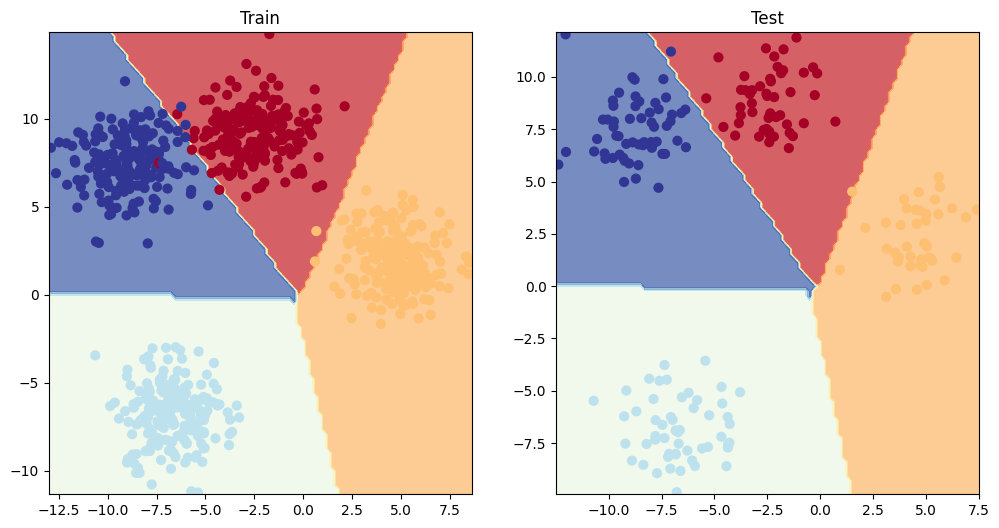

In [24]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_blob_test, y_blob_test)

plt.show()

In [25]:
accuracy_fn(y_pred=y_pred, y_true=y_blob_test)

99.0

### Further Evaluation

- Accuracy
- Precision
- Recall
- F1-score
- Confusion matrix
- Classification matrix

In [32]:
!pip install torchmetrics -q

In [31]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

torchmetric_accuracy(y_pred, y_blob_test).item()

0.9900000095367432